<center><h1>Calculating errors on the forecasts using hindcasts<h1></center>
 <center><img src="../AC_logo.png"></center>

<center><font size = "6"> What are hindcasts? <br><br> Hindcasts are just forecasts performed on historical data where the outcome is already known. <br><br> They are a common way of testing how well mathematical models perform and we will be using them to calculate how well the Gaussian process forecast method performs in each county. </font></center>

<center><font size = "6"> What will this look like when applied to the actual data? </font></center>

 <center><img src="../Hindcast_image.png"></center>

<center><font size = "6">To begin with, this notebook will follow the same steps as the last notebook.</font></center>

# AstroCast Error Calibration 

## Importing Modules

In [3]:
# Two modules included with anaconda distribution
# Modules can be imported 'as' something. This allows you to shorten the name as needed.

import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import warnings
from sklearn import metrics
warnings.filterwarnings('ignore')
%matplotlib inline

# Bespoke modules created using pyro to perform the Gaussian processes and then create reports.

import Forecasting

## Load in the data


In [4]:
# Loading in VCI data

Data = np.load('..\Data\VCI_Time_Series.npz',allow_pickle=True)

# Picking a county to run the GP on 


County = 'Kitui'

# Making sure each array has the correct format

Dates,VCI1W,VCI3M = np.array(Data[County][0],dtype=object),np.array(Data[County][2],dtype=float),np.array(Data[County][3],dtype=float)

# Errors will not be loaded in this time as they will be created here.

## The county list

In [5]:
# This cell simply goes through the file and shows what counties can be chosen.
# Simply copy and paste the county wanted into the cell above.

Counties = [] 
for item in Data:
    Counties.append(item)
print(Counties)

['Mombasa', 'Kwale', 'Kilifi', 'TanaRiver', 'Lamu', 'TaitaTaveta', 'Garissa', 'Wajir', 'Mandera', 'Marsabit', 'Isiolo', 'Meru', 'TharakaNithi', 'Embu', 'Kitui', 'Machakos', 'Makueni', 'Nyandarua', 'Nyeri', 'Kirinyaga', 'Muranga', 'Kiambu', 'Turkana', 'WestPokot', 'Samburu', 'TransNzoia', 'UasinGishu', 'ElgeyoMarakwet', 'Nandi', 'Baringo', 'Laikipia', 'Nakuru', 'Narok', 'Kajiado', 'Kericho', 'Bomet', 'Kakamega', 'Vihiga', 'Bungoma', 'Busia', 'Siaya', 'Kisumu', 'HomaBay', 'Migori', 'Kisii', 'Nyamira', 'Nairobi']


## Plot and check the data

In [6]:
def Weeklyplot(LowerBound,UpperBound):
    
    # List comprehension to change the format of the dates (Easier for plotting)

    PlottingDates = [dt.datetime.strptime(date, "%d-%m-%Y").date() for date in Dates.tolist()]

    # Setting the size for the plot

    plt.figure(figsize=(15,7)) 

    # Plotting the data and setting the colour and style of the line

    plt.plot(PlottingDates,VCI1W,color='r',linestyle='-')

    #Setting the size of the text on the x and y axis
    plt.xticks(size=18)
    plt.yticks(size=18)
    plt.ylabel('VCI3M',size=18)
    plt.xlabel('Date',size=18)
    plt.title('VCI1W Time Series',size=20)
    plt.xlim(PlottingDates[LowerBound],PlottingDates[UpperBound])
    plt.show()

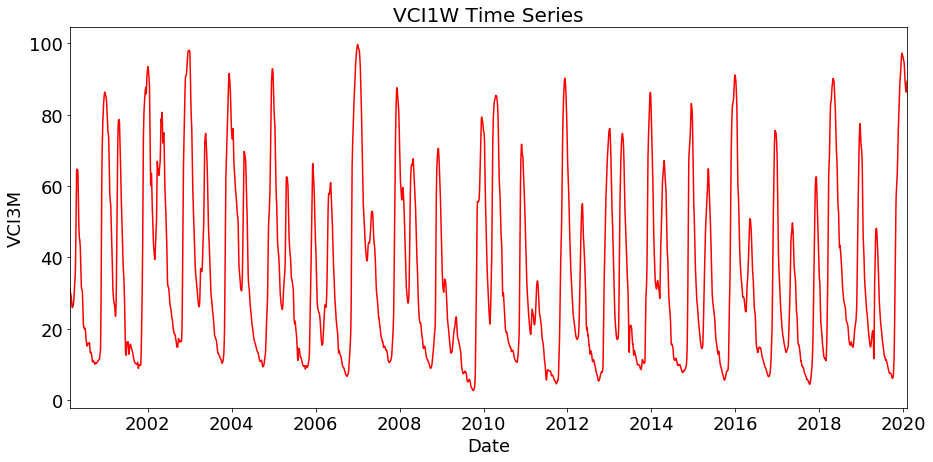

In [7]:
Weeklyplot(0,-1)

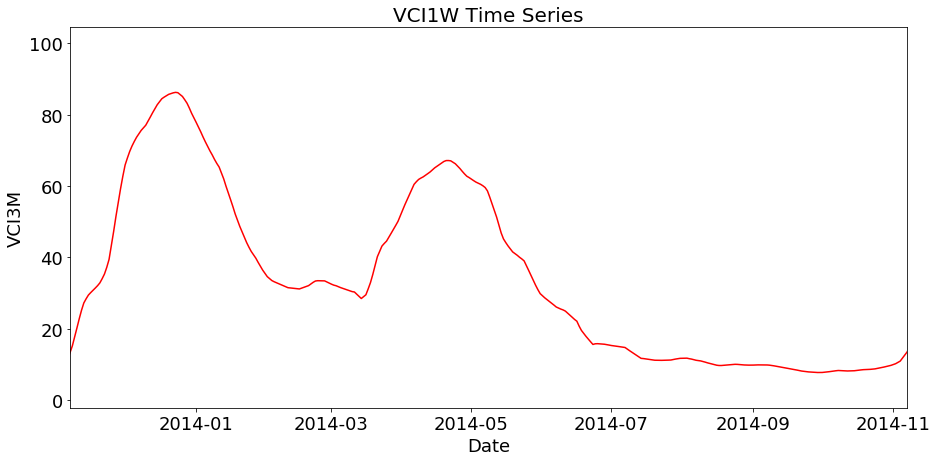

In [8]:
Weeklyplot(5000,5365)

<center><font size = "6"> Now we have the data all ready to go, we can pick how many hindcasts we want to perform.<br><br> The more hindcasts that are performed, the more reliable the calculated errors will be. <br><br> Each hindcast takes roughly 20s to be completed meaning processing time increases very quickly.</font></center>

In [28]:
# This will be the amount of weeks the program goes back, performs a prediction and compares it to the real data.
# It will automatically be ten weeks behind as we will be forecasting up to ten weeks in advance.

AmountOfHindcasts = 10

<center><font size = "6"> Now, we can run the hindcasts</font></center>

In [29]:
# Create empty arrays to store both hindcasts and actual values. 

Hindcasts = np.empty((AmountOfHindcasts,11))
ActualValues = np.empty((AmountOfHindcasts,11))

# Finding the remainder when the amount of data points is divided by 7. (Useful for turning daily values into weekly)

ToRemove = len(VCI3M) % 7

print('Amount of Hindcasts Performed')

# This for loop performs the amount of hindcasts requested on the data. 
# It saves the hindcasts and the actual values so they can be compared.


for LoopCounter in range(1,AmountOfHindcasts+1):
    
    ToIgnore,ToIgnore2,ToIgnore3,Hindcasts[LoopCounter-1,:] = \
    Forecasting.GetForecastVCI(Dates[:-(LoopCounter*7)-(10*7)],VCI1W[:-(LoopCounter*7)-(10*7)],VCI3M[:-(LoopCounter*7)-(10*7)])
    
    ActualValues[LoopCounter-1,:] = np.flip(VCI3M[ToRemove:][::-7])[-11-LoopCounter:-LoopCounter]
    
    print(LoopCounter, end=" ") 

Amount of Hindcasts Performed
1 2 3 4 5 6 7 8 9 10 

<center><font size = "6"> The for loop in the code above performs this process seen earlier.  <center><img src="../Hindcast_image.png"></center></font></center>

## Plot an example hindcast and the actual data to match

<center><font size = "6"> Now that we have the predicted hindcast values and the known values we can visualise the results. <br><br> We can plot the predicted time series alongside the actual time series. <br><br></font></center>

In [30]:
def HindcastVisuals():
    # Pick the hindcast you want to plot 

    HindcastNo = 0

    # Create an array with the week numbers ([0,1,2,3,...])

    WeekNumbers = np.arange(0,len(Hindcasts[0]),1)

    # Another, slightly more advanced code use to plot data.


    # Set up the axis and the size of the plot

    fig,ax1 = plt.subplots(figsize=(10,6))

    # Plot the actual data against the weekumber, and on the same figure, plot the forecasted data.
    # Label each line so that a key can be made to differentiate the two.

    ax1.plot(WeekNumbers,ActualValues[HindcastNo],label='Actual')
    ax1.plot(WeekNumbers,Hindcasts[HindcastNo],label='Forecasted')

    # Set a title alongside some labels for the axes. Fontsize can also be changed.

    ax1.set_title('Forecasted and Actual',fontsize=20)
    ax1.set_ylabel('VCI3M',fontsize=20)
    ax1.set_xlabel('Weeks Ahead',fontsize=20)

    # Changing the fontsize of tick labels for both VCI3M (y) and Weeks ahead (x)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Plotting the legend (key) and showing the plot
    plt.legend(fontsize=16)
    plt.show()

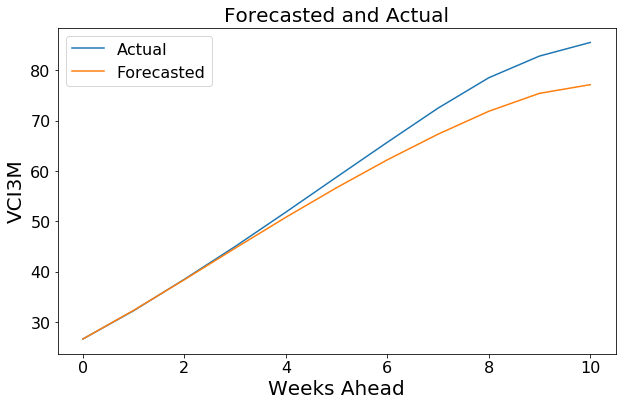

In [31]:
HindcastVisuals()

<center><font size = "6"> We can now visualise the spread of all hindcasts with respect to the actual values.<br><br> We will do this using a contour plot.</font></center>

In [32]:

def PlotContours(Hindcasts,ActualValues):
    # Set up the axes. We want 4 plots in a 2-by-2 grid.

    fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15, 15)) 

    # Choose how many bins each histogram should have.

    BinNo = 15

    # Create a 2-D histogram to show how spread our actual vs forecasted is.
    # A new histogram will be created for each different lead time. 
    # This first one will be 2 weeks ahead so we will access element 3 of the array. ([week0,week1,week2])


    counts,xbins,ybins = np.histogram2d(Hindcasts[:,3],ActualValues[:,3], bins=BinNo) 

    # Use a contour plot so visulise the spread in 2-D.

    ax1.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],\
                linewidths=10, cmap = plt.cm.BuPu)

    # Plot a black dotted line on the line x=y

    ax1.plot([0,100],[0,100], color = 'black', lw = 3, linestyle = '--')

    # Set the size of the axes labels and ticks as well as limits on the axes.

    ax1.set_xlim(0,100)
    ax1.set_ylim(0,100)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel('2 week Forecast VCI3M', size = 17)
    ax1.set_ylabel('True VCI3M', size = 17)


    # Now the same code is repeated, changing the lead time by 2 and changing the axis is is plotted on.

    counts,xbins,ybins = np.histogram2d(Hindcasts[:,5],ActualValues[:,5], bins=BinNo)

    ax2.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],\
                linewidths=10, cmap = plt.cm.BuPu)

    ax2.set_xlim(0,100)
    ax2.set_ylim(0,100)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.plot([0,100],[0,100], color = 'black', lw = 3, linestyle = '--')
    ax2.set_xlabel('4 week Forecast VCI3M', size = 17)
    ax2.set_ylabel('True VCI3M', size = 17)


    counts,xbins,ybins = np.histogram2d(Hindcasts[:,7],ActualValues[:,7], bins=BinNo)

    ax3.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],\
                linewidths=10, cmap = plt.cm.BuPu)

    ax3.set_xlim(0,100)
    ax3.set_ylim(0,100)
    ax3.tick_params(axis='both', which='major', labelsize=16)
    ax3.plot([0,100],[0,100], color = 'black', lw = 3, linestyle = '--')

    ax3.set_xlabel('6 week Forecast VCI3M', size = 17)
    ax3.set_ylabel('True VCI3M', size = 17)



    counts,xbins,ybins = np.histogram2d(Hindcasts[:,9],ActualValues[:,9], bins=BinNo)

    ax4.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],\
                linewidths=10, cmap = plt.cm.BuPu)

    ax4.set_xlim(0,100)
    ax4.set_ylim(0,100)
    ax4.tick_params(axis='both', which='major', labelsize=16)
    ax4.plot([0,100],[0,100], color = 'black', lw = 3, linestyle = '--')
    ax4.set_xlabel('8 week Forecast VCI3M', size = 17)
    ax4.set_ylabel('True VCI3M', size = 17)
    plt.show()

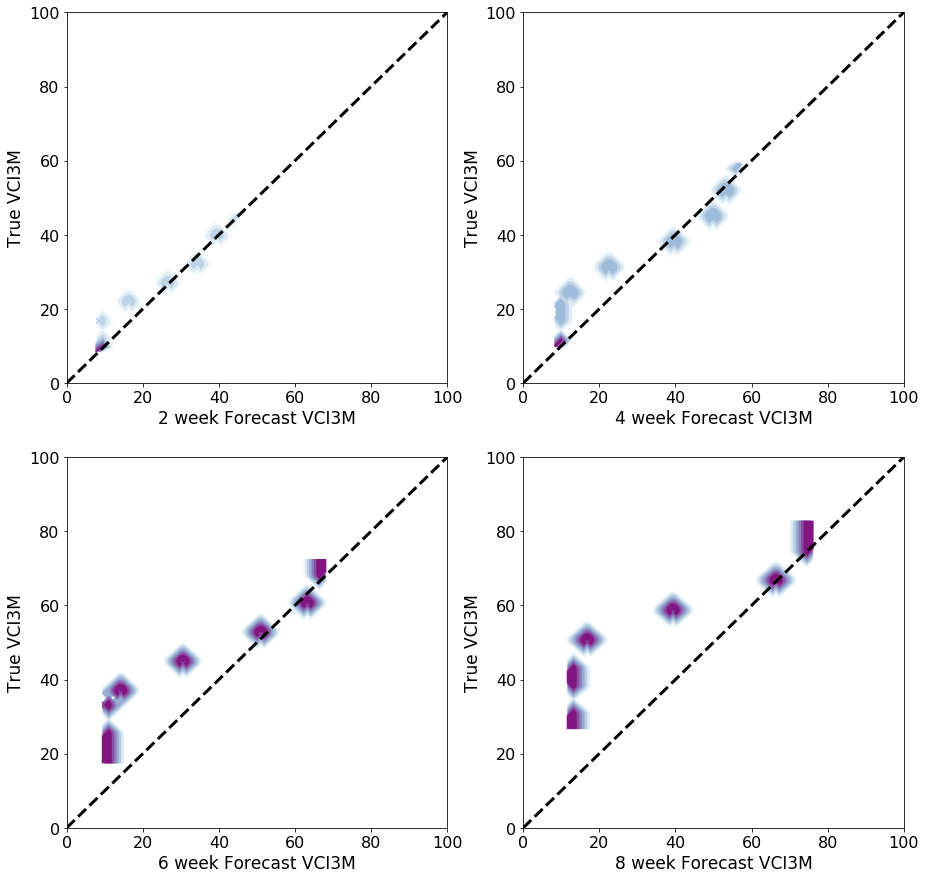

In [33]:
PlotContours(Hindcasts,ActualValues)

## The results can now be analysed

<center><font size = "6">We can now perform some statistical tests to measure how well the forecasts have done. <br><br> First, pick a lead time that we want to analyse. This can be from 0-10 weeks.</font></center>

In [34]:
# How many weeks ahead you want to calculate for

ForecastWeek = 9

<center><font size = "6"> Now we can calculate the R-squared score and the Root Mean Squared Error (RMSE).</font></center>

In [35]:
# Using a module called sklearn to calculate the metrics.

r2score = metrics.r2_score(ActualValues[:,ForecastWeek],Hindcasts[:,ForecastWeek])
RMSE    = metrics.mean_squared_error(ActualValues[:,ForecastWeek],Hindcasts[:,ForecastWeek])

# Printing out the R-Squared score and the RMSE.

print('R-Squared score:' , r2score)
print('Root Mean Squared Error:',RMSE)

R-Squared score: -0.022330925505709587
Root Mean Squared Error: 354.82237538055847


<center><font size = "6">Another useful approach is residual analysis. <br><br> Residuals are just the actual values minus the predicted values. <br><br> This is what is used within the reports to give an uncertainty on the forecasts.</font></center>

<center><font size = "6">Quick Gaussian statistics recap <br><br> We first calculate what the standard deviation of our residuals are. <br><br> This allows us to say how confident we are that the real data will follow our forecast</font></center>

<center><img src="../Gaussian.png"></center>

#### Residual analysis

<center><font size = "6">We can now calculate the residuals along with the mean and standard deviation of them.</font></center>

In [36]:
# Calculate the Residuals. This is simply the real value - the predicted value

Difference = ActualValues - Hindcasts

# The mean and standard deviation of the residuals can now be calculated.

Mean = np.round(np.mean(Difference,0),2)

StandardDeviation = np.round(np.std(Difference,0),2)

# The standard deviation is used in the reports to give us an uncertainty.
# We use +/- two standard deviations so that we are 95% condfident our forecast will fall within it.

print('Starting at 0 weeks (Mean and Std 0), going up to 10 weeks ahead')
print('Mean',Mean)
print('Std ',StandardDeviation)



Starting at 0 weeks (Mean and Std 0), going up to 10 weeks ahead
Mean [ 0.    0.35  0.91  1.77  3.05  4.79  6.94  9.43 12.18 15.08 18.06]
Std  [ 0.    0.61  1.53  2.68  3.96  5.3   6.71  8.18  9.68 11.29 13.02]


## Add the calibrated errors onto a new forecast.

#### Run the GP on the latest time series (Not a hindcast)

<center><font size = "6">We can now perform a brand new forecast from the latest data and apply the error calibration</font></center>

In [37]:
PredictionDates,WeeklyDates,WeeklyVCI3M,PredictedValues = Forecasting.GetForecastVCI(Dates,VCI1W,VCI3M)

<center><font size = "6">We can now pick how confident we want to be. We generally use two standard deviations which is 95% confident</font></center>

In [38]:
# How many standard deviations you want the error to include. 

AmountOfStds = 3

# Below are the confidence levels for each standard deviation in percentage.

ConfidenceLevels = [66,95,99]


# The colours of the confidence levels

Colours = ['red','blue','green']



<center><font size = "6">We can not pick how confident we want to be. We generally use two standard deviations which is 95% confident</font></center>

In [39]:
def PlotNewForecast(AmountofStds,ConfidenceLevels,Colours):
    # Adjusting the figure size

    fig,ax1 = plt.subplots(figsize=(15,7))

    # Shading in the graph to represent the possible error on the forecast. (95% confidence interval)

    for i in range(AmountOfStds,0,-1):
        ax1.fill_between(PredictionDates, PredictedValues-(i*StandardDeviation)+Mean,\
                         PredictedValues+(i*StandardDeviation)+Mean,lw=3,
                         color=Colours[i-1],alpha=0.6,label=(str(ConfidenceLevels[i-1])+' % confident'))

    # Plotting the actual forecast line
    ax1.plot(PredictionDates,PredictedValues,linestyle = '-' ,lw = 4, color = 'black')

    # Setting the title
    ax1.set_title('Forecast for ' + County,size=20)

    # Labeling the axes
    ax1.set_ylabel('VCI3M',size=18)
    ax1.set_xlabel('Date',size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
    ax1.legend()
    plt.show()

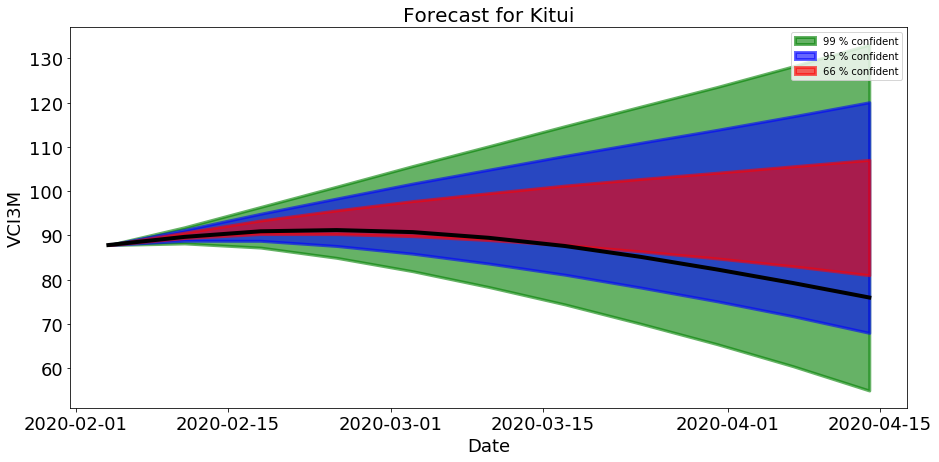

In [40]:
PlotNewForecast(AmountOfStds,ConfidenceLevels,Colours)